# MOVIE GENRE WITH BRNN

This is classification based one 0 and 1.The dataset is in .csv format

## Import necessary librarirs

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,confusion_matrix


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df=pd.read_csv(r"C:\Users\USER\OneDrive\Desktop\deep learning pjt\movie_data.csv",header=None)

In [3]:
df=df.sample(frac=1)

In [4]:
df.reset_index(drop =True,inplace= True)

In [5]:
df=df[0:5000]

In [6]:
df.head()

,0,1
0,"For me, North and South (Books I&II) is the ul...",1
1,"This is a beautiful, funny, vivid film. It's e...",1
2,***SPOILERS*** ***SPOILERS***<br /><br />I saw...,0
3,I went to see this movie with a lady freind of...,1
4,"I generally find Loretta Young hard to take, t...",1


## check info

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5000 non-null   object
 1   1       5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


## check for missing values

In [8]:
df.isna().sum()

0    0
1    0
dtype: int64

## drop missing rows

In [9]:
df.dropna(inplace =True)

## print some of text along with its label

In [10]:
for i in range(5):
    print(df[1][i],"--",df[0][i])
    print()

1 -- For me, North and South (Books I&II) is the ultimate TV series of the 80's. Just spotting all those cameo appearances was highly entertaining.Gene Kelly, James Stewart, Elisabeth Taylor, Olivia De Havilland, Robert Mitchum, even Johny CashÂ¡ No series has come close to this achievement.Have you ever seen anyone looking like Lincoln? Dick Smith's prosthetics made Hal Holbrock's powerful performance even more so. The crafted costumes, the jaw dropping locations, everything. It's clear that nowadays there are excellent and bright TV series (Desperate Housewives, Lost,24) but North & South was, and still is, one of its kind. Don't miss it. Only David Carradine's portrayal of the ultimate villain (you may call him just violent husband) worths the viewing. Maybe some characters and situations are too stereotyped, I admit it but the positive sides clearly cast a shadow over them. I'm so glad that finally is available on DVD in Spain.

1 -- This is a beautiful, funny, vivid film. It's eve

## create a function to preprocessing the text

In [11]:
texts = df[0].astype(str).tolist()
labels = df[1].astype(str).tolist()

# Text Preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

In [12]:
texts_cleaned = [clean_text(t) for t in texts]

## print some of the texts after the applying the function

In [13]:
for i in range(5):
    print(df[1][i],"--",df[0][i])
    print()


1 -- For me, North and South (Books I&II) is the ultimate TV series of the 80's. Just spotting all those cameo appearances was highly entertaining.Gene Kelly, James Stewart, Elisabeth Taylor, Olivia De Havilland, Robert Mitchum, even Johny CashÂ¡ No series has come close to this achievement.Have you ever seen anyone looking like Lincoln? Dick Smith's prosthetics made Hal Holbrock's powerful performance even more so. The crafted costumes, the jaw dropping locations, everything. It's clear that nowadays there are excellent and bright TV series (Desperate Housewives, Lost,24) but North & South was, and still is, one of its kind. Don't miss it. Only David Carradine's portrayal of the ultimate villain (you may call him just violent husband) worths the viewing. Maybe some characters and situations are too stereotyped, I admit it but the positive sides clearly cast a shadow over them. I'm so glad that finally is available on DVD in Spain.

1 -- This is a beautiful, funny, vivid film. It's eve

## check for imbalance in the dataset

C:\Users\USER\AppData\Local\Temp\ipykernel_308908\2480100904.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[1],palette="rainbow")


<Axes: ylabel='count'>

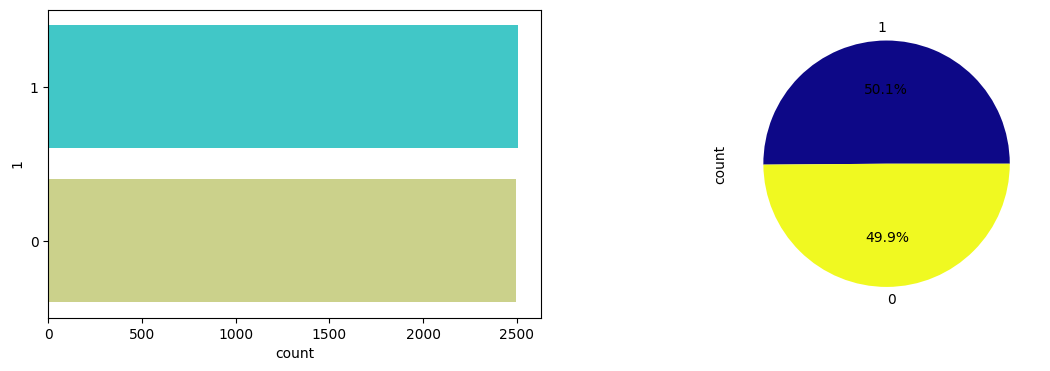

In [14]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.countplot(y=df[1],palette="rainbow")
plt.subplot(1,2,2)
df[1].value_counts().plot.pie(autopct ="%1.1f%%" ,cmap="plasma")

## split the dataset into inut & target variables

In [15]:
X=df[0]
y=df[1]

### Create Keras tokenizer object with 5000 max words
* Convert text to sequence
* Add padding

In [16]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_cleaned)
sequences = tokenizer.texts_to_sequences(texts_cleaned)
max_len = max(len(seq) for seq in sequences)
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# Label Encoding
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
y_cat = to_categorical(y)

### Split the dataset into Training & Testing set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(padded, y_cat, test_size=0.2, random_state=42)


In [18]:
# Class Weights
y_int = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weights_dict = dict(enumerate(class_weights))

### Create keras Sequential model with Bidirectional LSTM layers

In [19]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### compile the model

In [20]:
model.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])

### convert data into numerical data type

In [21]:
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

### train the model

In [34]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[es]
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9778 - loss: 0.0862 - val_accuracy: 0.8125 - val_loss: 0.5326
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9935 - loss: 0.0327 - val_accuracy: 0.8188 - val_loss: 0.6585
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9975 - loss: 0.0119 - val_accuracy: 0.7900 - val_loss: 0.7703
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9999 - loss: 0.0043 - val_accuracy: 0.8163 - val_loss: 0.7871


### make prediction with X_test

In [35]:
y_pred = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step


### Fetch the index of the higher probable prediction

In [36]:
print(y_pred.shape)

(1000, 2)


In [37]:
print(y_test.shape)

(1000, 2)


### Evaluate the model

### Accuracy score

In [26]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [27]:
y_true_labels = np.argmax(y_test, axis=1)


In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true_labels, y_pred_labels)


0.827

### Confusion matrix

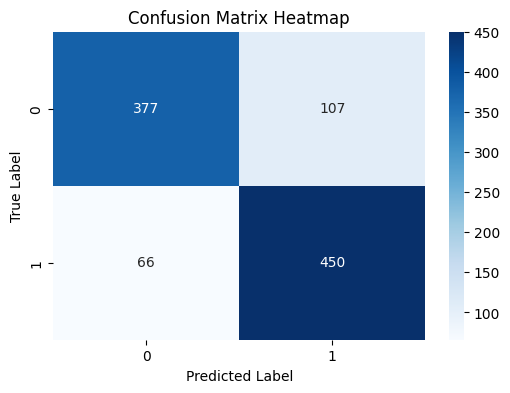

In [43]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot = True, fmt = 'd',cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Classification Report

In [45]:
print(classification_report(y_true_labels, y_pred_labels, target_names=encoder.classes_))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       462
           1       0.88      0.82      0.85       538

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



### Plot a graph to check the accuracy of our prediction

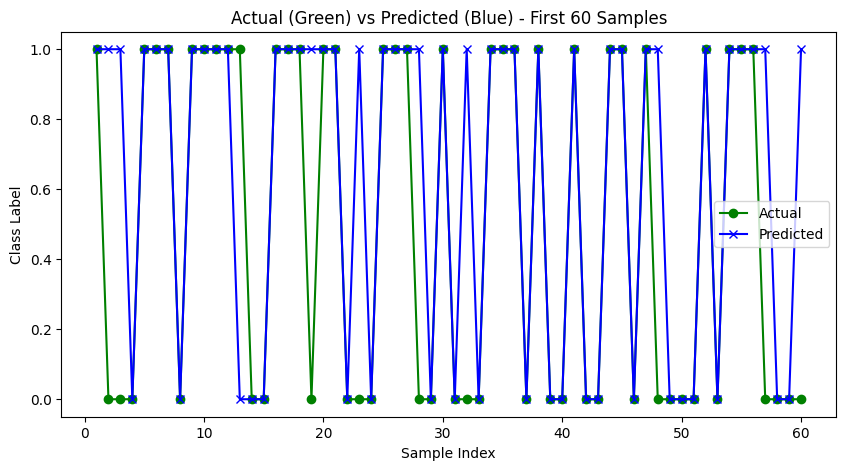

In [49]:
y_true_60 = y_true_labels[:60]
y_pred_60 = y_pred_labels[:60]

# Create x-axis index
c = list(range(1, 61))  # Index from 1 to 60

# Plot
fig = plt.figure(figsize=(10, 5))
plt.plot(c, y_true_60, color='green', marker='o', label='Actual')
plt.plot(c, y_pred_60, color='blue', marker='x', label='Predicted')

plt.title('Actual (Green) vs Predicted (Blue) - First 60 Samples')
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.legend()